# Imports


In [219]:
# Import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [220]:
# Import Data
path = '../data/raw/'
data = pd.read_csv(path+'HR_comma_sep.csv')
data.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Initial look 


In [221]:
# Get a sense of the datastructures
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


# Renaming columns

Some column names are capitalised, others arn't

In [222]:
# Return a uniform DataFrame
df0 = data.rename(columns = {
    'time_spend_company':'years_spent_company',
    'Work_accident':'work_accident',
    'Department':'department'
})

# Missing values

In [223]:
# Check for Missing Values
df0.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
years_spent_company      0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There are no missing values in the dataset 

# Duplicates

In [224]:
# Check for duplicated Values
print(f'{df0.duplicated().sum()} duplicated values in dataset')

3008 duplicated values in dataset


It seems highly unlikely that two employees would have the exact same scores on 11 different dimensions so droping duplicates seems a reasonable course in this situation

In [225]:
# Get a new DataFrame with duplicates removed
df1 = df0.drop_duplicates(keep='first')
#Chack if duplicates were removed
df0.shape[0] - df1.shape[0]

3008

# Check for outliers 

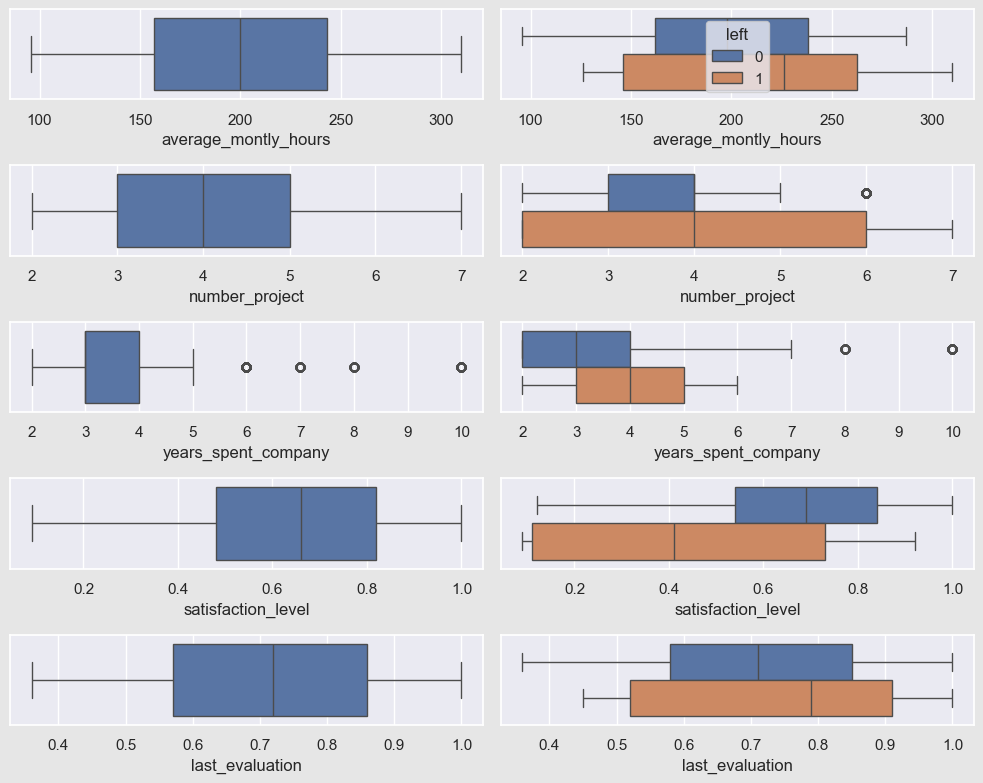

In [226]:
fig,ax = plt.subplots(5,2,figsize=(10,8))

# 
sns.set_palette('colorblind')
sns.set(rc={'figure.facecolor':'#e6e6e6'})

# Boxplots of numeric variables
sns.boxplot(data=df1,x='average_montly_hours',ax=ax[0,0])
sns.boxplot(data=df1,x='number_project',ax=ax[1,0])
sns.boxplot(data=df1,x='years_spent_company',ax=ax[2,0])
sns.boxplot(data=df1,x='satisfaction_level',ax=ax[3,0])
sns.boxplot(data=df1,x='last_evaluation',ax=ax[4,0])

# plots divided by departures 
sns.boxplot(data=df1,x='average_montly_hours',hue='left',ax=ax[0,1])
sns.boxplot(data=df1,x='number_project',hue='left',legend=None,ax=ax[1,1])
sns.boxplot(data=df1,x='years_spent_company',hue='left',legend=None,ax=ax[2,1])
sns.boxplot(data=df1,x='satisfaction_level',hue='left',legend=None,ax=ax[3,1])
sns.boxplot(data=df1,x='last_evaluation',hue='left',legend=None,ax=ax[4,1])

# Clean 
plt.tight_layout()
plt.show()



Most outliers are present in the years_spent_company metric, particularily in the stayed category.

There are allready some interesting paterns emerging in 'number_project','years_spent_company' and 'satisfaction_level' to be investigated later

In [227]:
#   Checking how many outliers are present in years_spent_company

upper_percentile = df1[['years_spent_company']].quantile(0.75).iloc[0]
lower_percentile = df1[['years_spent_company']].quantile(0.25).iloc[0]
iqr = upper_percentile-lower_percentile

outliers_df = df1[(df1['years_spent_company']>upper_percentile + 1.5*iqr) | (df1['years_spent_company']<lower_percentile - 1.5*iqr)]

print(f"{outliers_df.shape[0]} outliers in years_spent_company column wich is {(outliers_df.shape[0]/df1.shape[0]*100):.2f}% of the column")

824 outliers in years_spent_company column wich is 6.87% of the column


'years_spent_company' has 6.87% outliers in it. We will have to watch out when picking a model not to choose one sensitive to outliers

# Check Output Proportions

In [228]:
df1['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

In [229]:
total_leave_count = df1['left'].value_counts()[1]

# Check for Correlations

<Axes: >

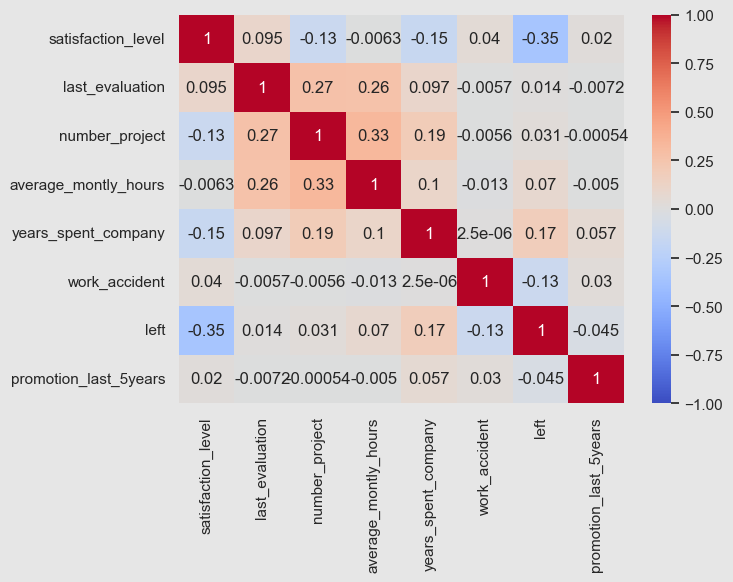

In [230]:
# Get a correlation Matrix
matrix = df1.corr(method='pearson',numeric_only=True)

sns.heatmap(matrix,vmin=-1,vmax=1,annot=True,cmap='coolwarm')

The five greatest correlations are : 

- Between 'left' and 'satisfaction_level' : -0.35
- Between 'average_montly_hours' and 'number_project' : 0.33
- Between 'last_evaluation' and 'number_project' : 0.27
- Between 'last_evaluation' and 'average_montly_hours' : 0.26
- Between 'years_spent_company' and 'number_project' : 0.19

# Inspection of Dimensions

## Work_accident column inspection

In [231]:
# Get a sense of proportions
df1['work_accident'].value_counts(normalize=True)

work_accident
0    0.845718
1    0.154282
Name: proportion, dtype: float64

15% of Employees have been victim of a work accident. At first glance, it seems like a lot

In [232]:

# Get a Table representing Departures By Work Accident
work_accident_leave = df1.groupby(['work_accident'])['left'].value_counts(normalize=True).unstack().reset_index()
# Cleanup Table
work_accident_leave.index = ['Stayed', 'Left']
work_accident_leave.drop(['work_accident'],axis=1,inplace=True)
work_accident_leave.columns = ['None','Accident']
# Visualize Table
work_accident_leave.head()

,None,Accident
Stayed,0.814022,0.185978
Left,0.943243,0.056757


Based on this data, victims of a work accident do not seem more likely to leave.

<Axes: xlabel='average_montly_hours', ylabel='Count'>

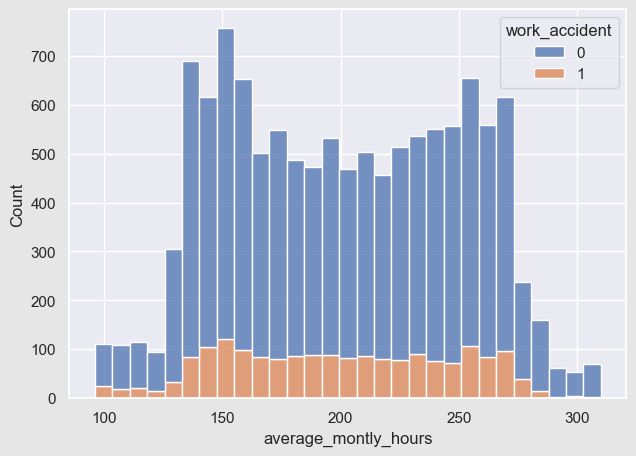

In [233]:
# Visualize the distribution of accidents
sns.histplot(df1,x='average_montly_hours',hue='work_accident',multiple='stack')

In [234]:
work_bins = [0,50,100,150,200,250,300]

accident_by_hours_worked_df = (
    df1.groupby([pd.cut(df1['average_montly_hours'],work_bins),'work_accident'])
    .size()
    .unstack()
)

accident_by_hours_worked_df['percent_of_accident'] = accident_by_hours_worked_df[1]*100 / (accident_by_hours_worked_df[0] + accident_by_hours_worked_df[1])
accident_by_hours_worked_df['total_of_workers'] = (accident_by_hours_worked_df[0] + accident_by_hours_worked_df[1])

(
    accident_by_hours_worked_df[['total_of_workers','percent_of_accident']]
    .fillna(0)
    .tail(5)
)

C:\Users\max05\AppData\Local\Temp\ipykernel_20684\1482591791.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['average_montly_hours'],work_bins),'work_accident'])


work_accident,total_of_workers,percent_of_accident
average_montly_hours,,
"(50, 100]",67,23.880597
"(100, 150]",2261,14.329943
"(150, 200]",3717,16.411084
"(200, 250]",3536,15.639140
"(250, 300]",2318,14.797239


In [235]:
df1.groupby(['number_project'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).rename(columns={1:'Percent of work accident'}).style.bar(color='grey',vmax=1)

work_accident,Percent of work accident
number_project,
2,0.111252
3,0.175852
4,0.160651
5,0.156740
6,0.134383
7,0.013793


In [236]:
df1.groupby(['years_spent_company'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).rename(columns={1:'Percent of work accident'}).style.bar(color='grey',vmax=1)

work_accident,Percent of work accident
years_spent_company,
2,0.171821
3,0.149711
4,0.137656
5,0.140301
6,0.162362
7,0.138298
8,0.271605
10,0.233645


In [237]:
df1.groupby(['department'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).sort_values(by=1,ascending=False).rename(columns={1:'Percent of work accident'}).style.bar(color='grey',vmax=1)

work_accident,Percent of work accident
department,
RandD,0.171470
management,0.165138
support,0.164195
marketing,0.160475
product_mng,0.158892
sales,0.153751
technical,0.151070
IT,0.142418
accounting,0.140097


Analysis does not reveal a clear correlation between work accidents and another dimension. Most of the variance can be attributed to smaller samples at the tails

## 'Promotion_last_5years' column inspection

In [238]:
# Check Proportions
df1['promotion_last_5years'].value_counts(normalize=True)

promotion_last_5years
0    0.983071
1    0.016929
Name: proportion, dtype: float64

In [239]:
# Get a Table representing Departures By Promotions
promotion_leave = df1.groupby(['promotion_last_5years'])['left'].value_counts(normalize=True).unstack().reset_index()
# Cleanup Table
promotion_leave.index = ['Stayed', 'Left']
promotion_leave.drop(['promotion_last_5years'],axis=1,inplace=True)
promotion_leave.columns = ['None','Promotion']
# Visualize Table
promotion_leave.head()

,None,Promotion
Stayed,0.831778,0.168222
Left,0.960591,0.039409


Based on data, employees that did not get a raise in the last 5 years seem to be much more likely to leave. Further investigation could be beneficial. Also, there doesn't seem to be a lot of promoting in Saliford Motors. Creating new echelons could bring a sense of progression to keep engagement high.

In [240]:
# Check for a link Between Evaluation and Promotions
bins = [0,0.2,0.4,0.6,0.8,1]

promotion_by_evaluation_df = (
    df1.groupby([pd.cut(df1['last_evaluation'],bins),'promotion_last_5years'])
    .size()
    .unstack()
)

promotion_by_evaluation_df['count_of_employees'] = promotion_by_evaluation_df[1] + promotion_by_evaluation_df[0]
promotion_by_evaluation_df['percent_promoted'] = promotion_by_evaluation_df[1]*100/(promotion_by_evaluation_df[0]+promotion_by_evaluation_df[1])

(
    promotion_by_evaluation_df
    .drop(columns=[0])
    .rename(columns={1:'Number of promotions'})
)

C:\Users\max05\AppData\Local\Temp\ipykernel_20684\1745923646.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['last_evaluation'],bins),'promotion_last_5years'])


promotion_last_5years,Number of promotions,count_of_employees,percent_promoted
last_evaluation,,,
"(0.0, 0.2]",0,0,NaN
"(0.2, 0.4]",8,201,3.980100
"(0.4, 0.6]",56,3622,1.546107
"(0.6, 0.8]",77,3883,1.983003
"(0.8, 1.0]",62,4285,1.446908


Promotions do not appear to be related to employees last evaluation.

In [241]:
# Check for a link between Satisfaction and Promotions
bins = [0,0.2,0.4,0.6,0.8,1]

promotion_by_evaluation_df = (
    df1.groupby([pd.cut(df1['satisfaction_level'],bins),'promotion_last_5years'])
    .size()
    .unstack()
)

promotion_by_evaluation_df['count_of_employees'] = promotion_by_evaluation_df[1] + promotion_by_evaluation_df[0]
promotion_by_evaluation_df['percent_promoted'] = promotion_by_evaluation_df[1]*100/(promotion_by_evaluation_df[0]+promotion_by_evaluation_df[1])

(
    promotion_by_evaluation_df
    .drop(columns=[0])
    .rename(columns={1:'Number of promotions'})
)

C:\Users\max05\AppData\Local\Temp\ipykernel_20684\667511835.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['satisfaction_level'],bins),'promotion_last_5years'])


promotion_last_5years,Number of promotions,count_of_employees,percent_promoted
satisfaction_level,,,
"(0.0, 0.2]",8,994,0.804829
"(0.2, 0.4]",13,1184,1.097973
"(0.4, 0.6]",58,2872,2.019499
"(0.6, 0.8]",64,3599,1.778272
"(0.8, 1.0]",60,3342,1.795332


There does appear to be a link between Satisfaction levels and Promotions.

In [242]:
# Check for a link between number of projects and Promotions
(
    df1.groupby(['number_project'])
        ['promotion_last_5years']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .drop(columns=[0])
        .rename(columns={1:'percent_of_promotion_given'})
        .style.bar(color='grey',vmax=1)
)

promotion_last_5years,percent_of_promotion_given
number_project,
2,0.012010
3,0.017614
4,0.020624
5,0.014778
6,0.015738
7,0.000000


There does seem to be a link between number of projects and promotions

In [243]:
# Check for a link between promotions and monthly hours
bins = [100,150,200,250,300]

promotion_by_evaluation_df = (
    df1.groupby([pd.cut(df1['average_montly_hours'],bins),'promotion_last_5years'])
    .size()
    .unstack()
)

promotion_by_evaluation_df['count_of_employees'] = promotion_by_evaluation_df[1] + promotion_by_evaluation_df[0]
promotion_by_evaluation_df['percent_promoted'] = promotion_by_evaluation_df[1]*100/(promotion_by_evaluation_df[0]+promotion_by_evaluation_df[1])

(
    promotion_by_evaluation_df
    .drop(columns=[0])
    .rename(columns={1:'Number of promotions'})
)

C:\Users\max05\AppData\Local\Temp\ipykernel_20684\2515429049.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['average_montly_hours'],bins),'promotion_last_5years'])


promotion_last_5years,Number of promotions,count_of_employees,percent_promoted
average_montly_hours,,,
"(100, 150]",44,2261,1.946042
"(150, 200]",57,3717,1.533495
"(200, 250]",65,3536,1.838235
"(250, 300]",36,2318,1.553063


There does not seem to be a link between monthly hours and promotions

## 'Salary' column inspection

In [244]:
# Check for proportions in salary
salary_proportion = pd.DataFrame(df1['salary'].value_counts(normalize=True))
salary_proportion.style.bar(color='grey',vmax=1)

,proportion
salary,
low,0.478692
medium,0.438746
high,0.082562


In [245]:
# Check for correlation with output variable
salary_df = (
    pd.DataFrame(
    df1[['salary','left']]
    .groupby('salary')
    .value_counts()
    .unstack()
    )
)

<Axes: xlabel='salary'>

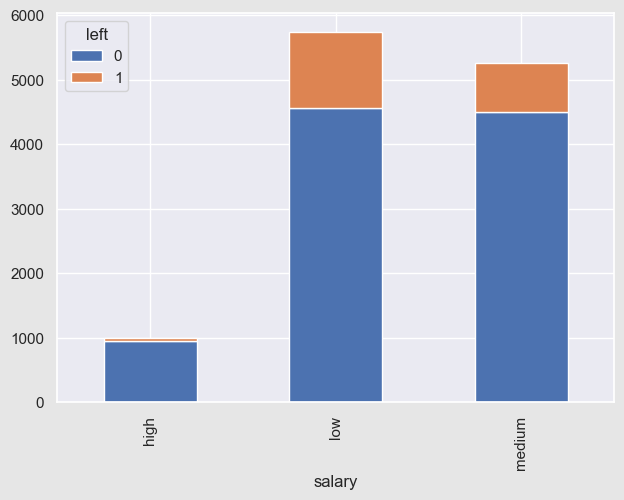

In [246]:
# Visualize on a bar graph
salary_df.plot.bar(stacked=True)

    We can see from the data that higher paid staff are more likely to stay.

## 'Department' column inspection

In [247]:
# Check for proportions in the departments
department_proportion = pd.DataFrame(df1['department'].value_counts(normalize=True).round(2))

In [248]:
# Return a Table of departures for each department
department_df = (
    pd.DataFrame(
    df1[['department','left']]
    .groupby('department')
    .value_counts()
    .unstack()
    )
)
# Cleanup Dataframe
department_df['percent_left'] = round(department_df[1] / (department_df[0]+department_df[1]),2)
department_df = department_df.sort_values(by='percent_left',ascending=False)
# Add the proportion of the company represented by the department to the table
department_df[['percent_left']].join(department_proportion).rename(columns={'proportion':'proportion_of_company_staff'}).style.bar(color='grey',vmax=1)

,percent_left,proportion_of_company_staff
department,,
hr,0.190000,0.050000
accounting,0.180000,0.050000
technical,0.170000,0.190000
support,0.170000,0.150000
marketing,0.170000,0.060000
sales,0.170000,0.270000
product_mng,0.160000,0.060000
IT,0.160000,0.080000
RandD,0.120000,0.060000


C:\Users\max05\AppData\Local\Temp\ipykernel_20684\1136966999.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=department_df,x='percent_left',y='department',palette=cols)


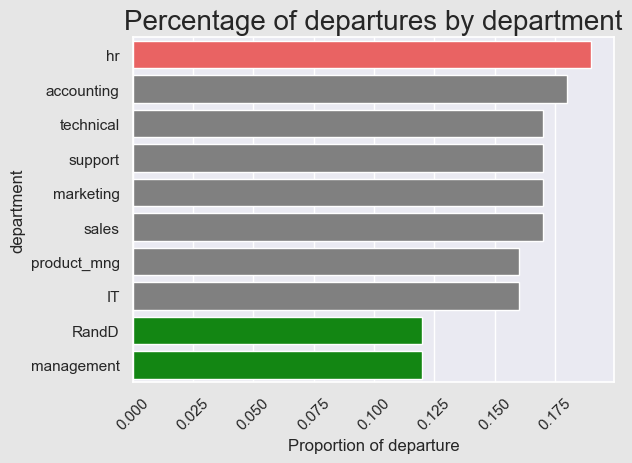

In [249]:
# Setup style for the graph
cols = ['#ff4d4d' if x>0.18 else '#009900' if x<0.13 else 'grey' for x in department_df.percent_left]
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.facecolor':'#e6e6e6'})
sns.set_palette('colorblind')
sns.set(rc={'figure.facecolor':'#e6e6e6'})

# Get a Graph of the departures by department
sns.barplot(data=department_df,x='percent_left',y='department',palette=cols)

# Cleanup Graph
plt.xticks(rotation=45)
plt.title('Percentage of departures by department',size=20)
plt.xlabel('Proportion of departure')
plt.tight_layout()
# Save a copy for final repport
plt.savefig('../reports/figures/departure_by_department.png')

3 departements stand out regarding tenure,

    HR has the most with 19%
    RandD and Management have the least with around 12%

In [250]:
# Check for correlations between salary and department since we know salary affect departures
salary_by_department_df = df1.groupby(by=['department','salary']).size().unstack()

salary_by_department_df['count'] = salary_by_department_df['high'] + salary_by_department_df['low'] + salary_by_department_df['medium']
salary_by_department_df['high_perc'] = salary_by_department_df['high']*100/salary_by_department_df['count']
salary_by_department_df['medium_perc'] = salary_by_department_df['medium']*100/salary_by_department_df['count']
salary_by_department_df['low_perc'] = salary_by_department_df['low']*100/salary_by_department_df['count']

(
salary_by_department_df
    .sort_values(by=['high_perc'],ascending=True)
    .drop(['count','high','medium','low'],axis=1)
    .style
    .bar(color='grey',vmax=100)
)

salary,high_perc,medium_perc,low_perc
department,,,
hr,6.322795,44.425957,49.251248
RandD,6.772334,46.829971,46.397695
support,6.919275,45.469522,47.611203
IT,7.274590,43.954918,48.770492
sales,7.317073,44.736030,47.946897
technical,7.397504,41.889483,50.713012
product_mng,7.580175,42.419825,50.000000
marketing,9.212481,44.725111,46.062407
accounting,10.144928,42.190016,47.665056


# Inspection of metrics

## Inspection of 'satisfaction_level' column

In [251]:
df1.satisfaction_level.describe()

count    11991.000000
mean         0.629658
std          0.241070
min          0.090000
25%          0.480000
50%          0.660000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

In [252]:
# Defining a breakpoint of 75% as being satisfied with the work environnement, we can look at how many employees fall into the category
satisfied_df = (df1[df1['satisfaction_level']>=0.75])

round(satisfied_df.shape[0]/df1.shape[0],2)

0.37

- We can see from the satisfaction statistics that satisfaction is mostly positive with a median of 66%

- About 37% of the employees surveyed report being above 75% satisfied wich could probably be improved

In [253]:
# we can compare descriptive stats of "statisfied" employees with the whole population
(
pd.DataFrame(satisfied_df.describe()-df1.describe())
.drop(['satisfaction_level'],axis=1)
.style
.hide(subset=['count','std','25%','75%'],axis=0)
)

,last_evaluation,number_project,average_montly_hours,years_spent_company,work_accident,left,promotion_last_5years
mean,0.029818,0.052149,5.374319,-0.041071,0.006604,-0.065348,0.001867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.040000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,-1.000000,-3.000000,0.000000,0.000000,0.000000,0.000000


Comparing high satisfaction statistics with the whole population reports that:

- The mean of their last evaluation is about 3% higher and they work on average 5.37 more hours monthly
- The average of their number of project is higher while the maximum of project is one less

Text(0.5, 1.0, 'Company TurnOver by Satisfaction')

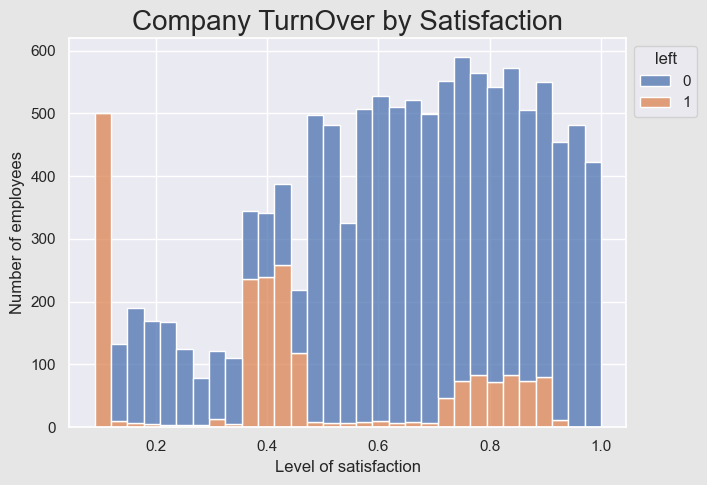

In [254]:
# Get a sense of the distribution of leave by Satisfaction levels
ax = sns.histplot(data=df1,x='satisfaction_level',hue='left',multiple='stack')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# Cleanup graph
plt.ylabel('Number of employees')
plt.xlabel('Level of satisfaction')
plt.title('Company TurnOver by Satisfaction',size = 20)


Population seems highly polarised with a group normalised around 70% and a smaller group normalised around 20%. Most of the departures occur in three separate groups. One of them is not satisfied at all, one other is about 40% satisfied and another is pretty satisfied at around 80%.

In [255]:
table_satisfaction_by_year = (
    df1[['satisfaction_level','years_spent_company']]
    .groupby(by='years_spent_company').mean()
    #.sort_values(by='satisfaction_level',ascending=False)
)

table_satisfaction_by_year = table_satisfaction_by_year.rename(columns={'satisfaction_level':'Average Satisfaction'})
table_satisfaction_by_year.index.name = 'Years'
table_satisfaction_by_year = (table_satisfaction_by_year)

In [256]:
# Return the table
table_satisfaction_by_year.style.bar(color='grey',vmax=1)

,Average Satisfaction
Years,
2,0.699165
3,0.648988
4,0.516090
5,0.583183
6,0.571107
7,0.635957
8,0.665062
10,0.655327


# Inspection of 'last_evaluation' column

In [257]:
# Get basic stats
df1['last_evaluation'].describe()

count    11991.000000
mean         0.716683
std          0.168343
min          0.360000
25%          0.570000
50%          0.720000
75%          0.860000
max          1.000000
Name: last_evaluation, dtype: float64

Text(0, 0.5, 'Number of employee')

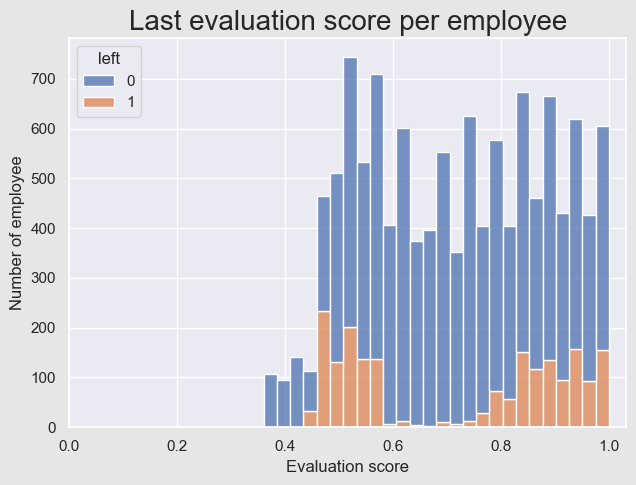

In [258]:
sns.histplot(data=df1,x='last_evaluation',hue='left',multiple='stack')
plt.xlim(left=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Last evaluation score per employee',size=20)
plt.xlabel('Evaluation score')
plt.ylabel('Number of employee')

Two distinct groups are evident in departures. From what we have gathered so far, we can hypothesize that the group of low performers might have been fired and the group of high performers could have gone for a higher paying job.

## Inspection of 'number_project' column

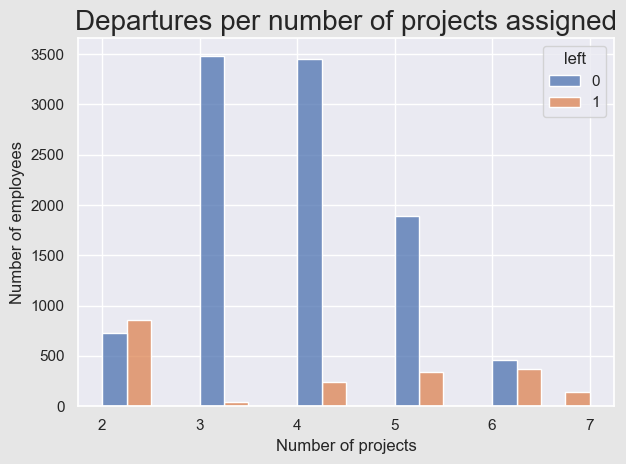

In [259]:
# Visualize departures by project number
sns.histplot(data=df1,x='number_project',hue='left',multiple='dodge',binwidth=0.5)

plt.title('Departures per number of projects assigned',size = 20)
plt.xlabel('Number of projects')
plt.ylabel('Number of employees')

plt.tight_layout()
plt.savefig('../reports/figures/leave_per_number_project.png') 

We can see a much lower proportion of leave betweeen 3 and 5 projects already

<Axes: xlabel='number_project', ylabel='satisfaction_level'>

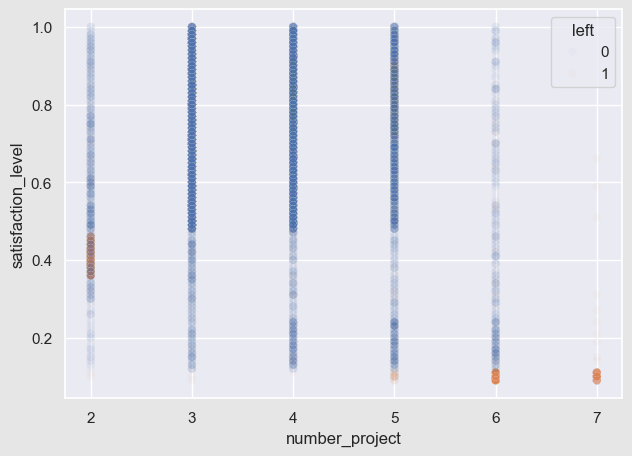

In [260]:
# Visualize the Satisfaction levels per number of projects
sns.scatterplot(data=df1,y='satisfaction_level',x='number_project',hue='left',alpha = 0.03)

Satisfaction seems much higher between 3 and 5 projects

In [261]:
# Create a table for departures by number of projects
number_project_df = (
    pd.DataFrame(
    df1[['number_project','left']]
    .groupby('number_project')
    .value_counts()
    .unstack()
    .fillna(0)
    )
)

In [262]:
# Updates results of the table to get percentage of leave and count of leave
number_project_df['percent_left'] = number_project_df[1]*100/(number_project_df[0]+number_project_df[1])
number_project_df['count'] = number_project_df[1] + number_project_df[0]

In [263]:
# Drop redundancy
number_project_df.drop([0,1],axis=1,inplace=True)

In [264]:
# Return Table with bar visualization
number_project_df.round(0).style.bar(color='grey')

left,percent_left,count
number_project,,
2,54.000000,1582.000000
3,1.000000,3520.000000
4,6.000000,3685.000000
5,15.000000,2233.000000
6,45.000000,826.000000
7,100.000000,145.000000


From the table we see that most of the company gets between 3 and 5 projects and that turnover percentage spikes outside of this range

    The totality of 145 workers with 7 projects assigned left the company regardless of their satisfaction levels. Assigning a maximum of 6 projects per employee might help with retention.

    Furthermore, keeping the number of projects assigned between 3 and 5 seems to be preferable for retention and satisfaction levels.

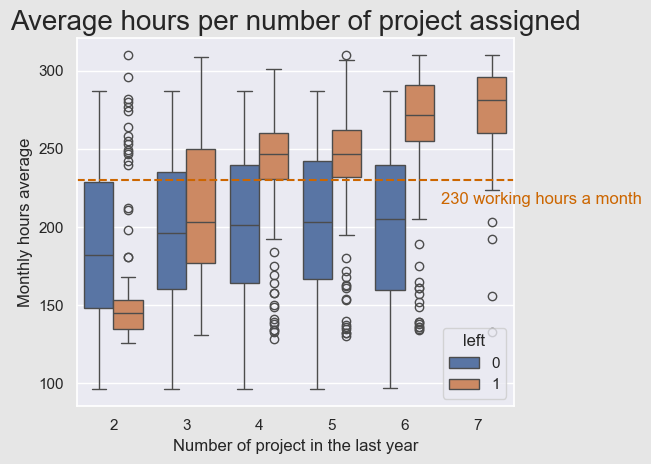

In [265]:
# Get a visual of statistics linking monthly hours to number of projects
sns.boxplot(data=df1,x='number_project',y='average_montly_hours',hue='left')
# Get a line to mark 230 hours a month
plt.axhline(y=230,color='#cc6600',linestyle = '--')
plt.annotate(text='230 working hours a month', xy= ( 4.5,215), color='#cc6600')
# Cleanup graph
plt.title('Average hours per number of project assigned',size = 20)
plt.xlabel('Number of project in the last year')
plt.ylabel('Monthly hours average')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
# Save fig for final report
plt.savefig('../reports/figures/monthly_hours_per_project.png') 

Looking further in the data we can see that even at high project count, departures seem to mostly occur when matched with high working hours. 

High project count with medium working hours do not seem to be associated with departure.

## Inspection of 'average_montly_hours' column

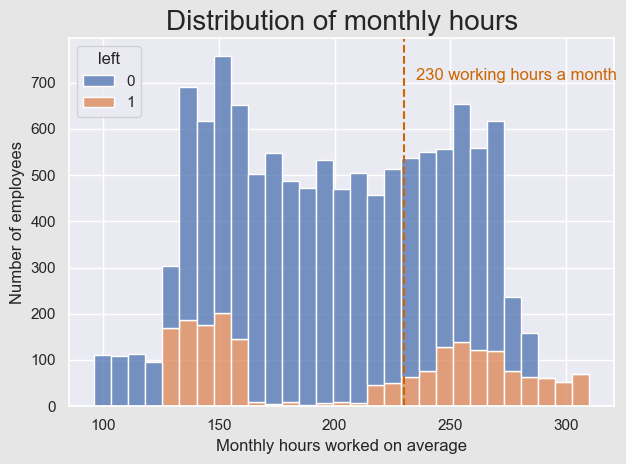

In [266]:
# Get a sense of the distribution of working hours split by departures
sns.histplot(data=df1,x='average_montly_hours',hue='left',multiple='stack')
# Plot a line to mark 230 hours a month
plt.axvline(x=230,color='#cc6600', linestyle= '--')
plt.annotate(text='230 working hours a month', xy= ( 235, 705), color='#cc6600')
# Cleanup Graph
plt.title('Distribution of monthly hours',size = 20)
plt.xlabel('Monthly hours worked on average')
plt.ylabel('Number of employees')
plt.tight_layout()
# Save fig for final report
plt.savefig('../reports/figures/distribution_of_monthly_hours_average.png') 

In [267]:
# get percent of leave under a recommended maximum hour threshold

# Set maximum hours
maximum_hour_recommended = 220
# Create dataframe of values under maximum recommended hours
under_max_hour_df = df1[df1['average_montly_hours']<=maximum_hour_recommended]


In [268]:
above_max_hour_leave_count = under_max_hour_df['left'].value_counts()[1]

In [269]:
percent_leave_above_recom_hour = (total_leave_count - above_max_hour_leave_count)/total_leave_count

print(f'{round(percent_leave_above_recom_hour*100,0)}% of departures occur over the recommended maximum hour threshold of {maximum_hour_recommended} hours')

52.0% of departures occur over the recommended maximum hour threshold of 220 hours


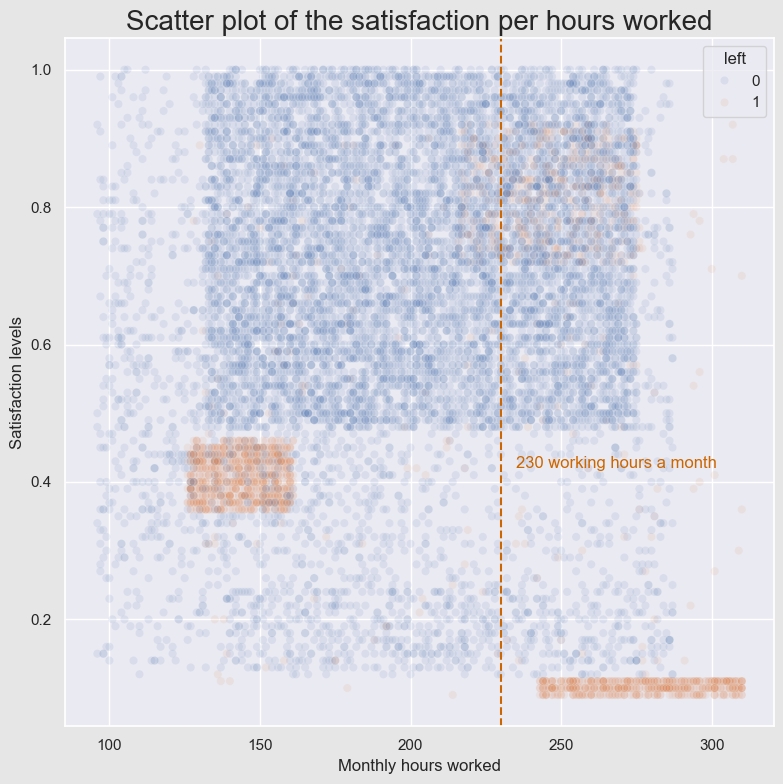

In [270]:
# Get a sense of the relation between satisfaction levels and monthly hours

plt.figure(figsize=(8,8))
sns.scatterplot(data=df1,x='average_montly_hours',y='satisfaction_level',hue='left',alpha=0.1)
# Plot a line to mark 230 hours a month
plt.axvline(x=230,color='#cc6600', linestyle= '--')
plt.annotate(text='230 working hours a month', xy= ( 235, 0.42), color='#cc6600')
# Cleanup graph
plt.title('Scatter plot of the satisfaction per hours worked', size = 20)
plt.xlabel('Monthly hours worked')
plt.ylabel('Satisfaction levels')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
# Save fig for final report
plt.savefig('../reports/figures/scatter_plot_satisfaction_vs_hours.png') 

3 areas can be identified on the scatter plot:
- High work hours, low satisfaction: Most likely left from burn out
- High work hours, high satisfaction: Most likely left for higher paid job
- Low work hours, low satisfaction: Most likely fired for low performance

## Inspection of 'years_spent_company' column

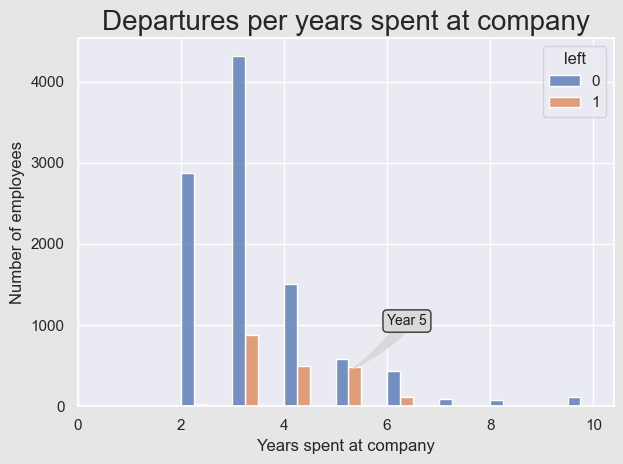

In [271]:
# Get a histogram of the company's tenure
sns.histplot(data=df1,x='years_spent_company',hue='left',multiple='dodge',binwidth=0.5)
# Cleanup Graph
plt.title('Departures per years spent at company', size = 20)
plt.xlabel('Years spent at company')
plt.ylabel('Number of employees')
plt.xlim(left=0)
# Point to the worst year by far
plt.annotate(text = 'Year 5',color = '#1a1a1a',
             xy = (5.3, 450),
             xytext= (6,1000),
             fontsize = 10,
             bbox = dict(boxstyle= 'Round',
                         fc = '#d9d9d9',
                         ec = '#333333'),
             arrowprops = dict(arrowstyle = 'wedge,tail_width=1.',
                               fc = '#d9d9d9',
                               ec = '#d9d9d9',
                               patchA = None,
                               connectionstyle = 'arc3,rad=-0.1'))
plt.tight_layout()
# Save fig for final report
plt.savefig('../reports/figures/leave_per_years_at_company.png') 

Most of the company have been with saliford for about 3 years with a big chunk of leave at the 5 year mark

In [272]:
# Get a table of the departures by year
table_departures_per_year = (
    df1[['years_spent_company','left']]
    .groupby(by='years_spent_company').value_counts(normalize=True)
    .unstack()
    [[1]]
    .rename(columns={1:'Percent of departures'})
    .round(2)
    .fillna(0)
    )

table_departures_per_year.style.bar(color='grey',vmax=1)

left,Percent of departures
years_spent_company,
2,0.010000
3,0.170000
4,0.250000
5,0.450000
6,0.200000
7,0.000000
8,0.000000
10,0.000000


In [273]:
# Get a sense of average satisfaction by tenure
average_satisfaction_by_tenure = df1.groupby(['years_spent_company','left'])['satisfaction_level'].mean().unstack().reset_index()
average_satisfaction_by_tenure.set_index('years_spent_company',inplace=True)
average_satisfaction_by_tenure.style.bar(color='grey',vmax=1)

left,0,1
years_spent_company,,
2,0.700907,0.537419
3,0.697020,0.411796
4,0.637901,0.144505
5,0.479121,0.708402
6,0.513880,0.798440
7,0.635957,nan
8,0.665062,nan
10,0.655327,nan


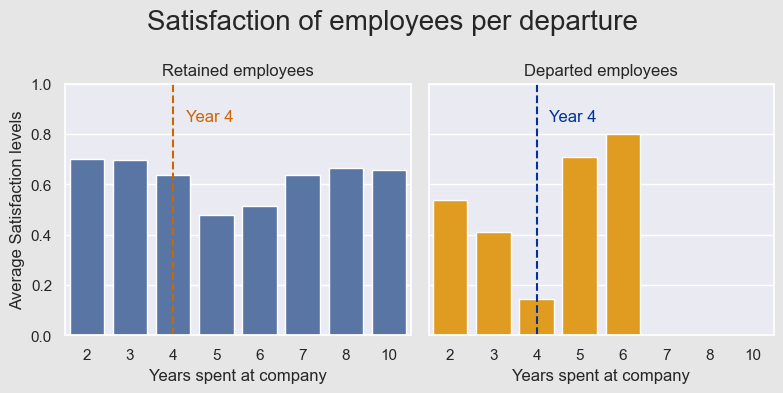

In [274]:
# get a better visualisation 
fig, ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
fig.suptitle('Satisfaction of employees per departure',fontsize=20)
# Graph retained employees
sns.barplot(average_satisfaction_by_tenure[0],ax=ax[0])

ax[0].set_title('Retained employees')
ax[0].set_ylim(top=1)
ax[0].set_ylabel('Average Satisfaction levels')
ax[0].set_xlabel('Years spent at company')
# Mark year 4 with a line
ax[0].axvline(x=2,color='#cc6600', linestyle= '--')
ax[0].annotate(text='Year 4', xy= ( 2.3, 0.85), color='#cc6600')
# Graph Departed employees
sns.barplot(average_satisfaction_by_tenure[1],ax=ax[1],color='orange')

ax[1].set_title('Departed employees')
ax[1].set_ylim(top=1)
ax[1].set_xlabel('Years spent at company')
ax[1].axvline(x=2,color='#003399', linestyle= '--')
ax[1].annotate(text='Year 4', xy= ( 2.3, 0.85), color='#003399')

plt.tight_layout()
# Save fig for final report
plt.savefig('../reports/figures/satisfaction_per_years_at_company.png') 

The 4 to 6 year mark seems to contribute a piece to the puzzle.

- retained personnel looks to be droping satisfaction in those 3 years
- The opposite is true for departed personnel in the years 5 and 6

In [275]:
# Split data into promotion or not
promoted_df = df1[df1['promotion_last_5years']==1]
non_promoted_df = df1[df1['promotion_last_5years']==0]

In [276]:
# Get a count of leave per promoted individuals
promoted_df = promoted_df.groupby(['years_spent_company','left'])['satisfaction_level'].count().unstack().reset_index()
promoted_df.set_index('years_spent_company',inplace=True)
promoted_df.columns = ['Stayed Count','Departed Count']
promoted_df['percent leave'] = promoted_df['Departed Count']/(promoted_df['Departed Count']+promoted_df['Stayed Count'])

In [277]:
promoted_df[['percent leave']].style.bar(color='grey',vmax=1)

,percent leave
years_spent_company,
2,nan
3,0.067416
4,0.045455
5,0.090909
6,nan
7,nan
8,nan
10,nan


In [278]:
# Get a count of leave per promoted individuals
non_promoted_df = non_promoted_df.groupby(['years_spent_company','left'])['satisfaction_level'].count().unstack().reset_index()
non_promoted_df.set_index('years_spent_company',inplace=True)
non_promoted_df.columns = ['Stayed Count','Departed Count']
non_promoted_df['percent leave'] = non_promoted_df['Departed Count']/(non_promoted_df['Departed Count']+non_promoted_df['Stayed Count'])

In [279]:
non_promoted_df[['percent leave']].style.bar(color='grey',vmax=1)

,percent leave
years_spent_company,
2,0.010798
3,0.170163
4,0.249117
5,0.457659
6,0.205273
7,nan
8,nan
10,nan


There is a definite increase in leave as the number of year without promotion increases in the company

In [280]:
# Save Dataset for modelisation
df1.to_csv(path[:-4]+'interim/HR_cleaned_dataset.csv')